In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# GlobalAveragePooling (GAP)
- 입력 Feature map의 채널별로 평균값을 추출하여 1 x 1 x channel 의 Feature map을 생성하는 Pooling
- `model.add(keras.layers.GlobalAveragePooling2D())`
![gap01](figures/09_gap_01.png)

- Feature Extraction layer에서 추출한 Feature map을 Classifier layer로 Flatten해서 전달하면 많은 연결노드와 파라미터가 필요하게된다.     
GAP를 사용하면 노드와 파라미터의 개수를 효과적으로 줄일 수 있다.
- Feature map의 채널수가 많을 경우 GAP를 사용하는 것이 효과적이나 채널수가 적다면 Flatten을 사용하는 것이 좋다.


![gap02](figures/09_gap_02.png)

# Pretrained Model

- (다른 목적을 위해)미리 학습된 모델.
- Pretrained model을 현재 해결하려는 문제에 이용한다.
- 대부분 내가 만들려는 네트워크 모델에 포함시켜 사용한다.
    - Pretrained Model의 Feature Extractor 부분(Backbone network)을 내가 만드는 모델의 Feature Extractor로 추가하여 모델을 구성한다.
    - 이런 방식을 Transfer Learning (전이 학습)이라고 한다.

## Keras에서 제공하는 Pretrained Model
- tensorflow.keras.applications 패키지를 통해 제공
    - https://www.tensorflow.org/api_docs/python/tf/keras/applications?hl=ko
    - Modules
        - 각 모델별 입력 Image 전처리 함수 제공
    - Functions
        - 각 모델 생성함수
- 모델 생성함수의 주요 매개변수
    - `weights`: 모델의 학습된 weight 지정.
        - 기본값- 'imagenet'. ImageNet 데이터셋으로 학습된 weight를 가진 모델 생성
    - `include_top`: fully connected layer(분류기)를 포함할지 여부. True 포함시킴, False: 포함 안 시킴
        - False를 지정하면 Feature Extractor인 Convolution Layer들로만 구성된 모델이 생성된다.
    - `input_shape`: Input(입력) 이미지의 크기 shape. 3D 텐서로 지정. (높이, 너비, 채널). 기본값: (224,224,3)
    

> 딥러닝 모델기반 application 개발시 대부분 Transfer Learning을 한다.  
> 다양한 분야에서 다양한 네트워크 모델들이 구현되어 공개 되어 있으며 학습된 Parameter들도 제공되고 있다.  
> [paperswithcode](https://paperswithcode.com/)에서 State Of The Art(SOTA) 논문들과 그 구현된 모델을 확인할 수 있다.

> **State Of The Art(SOTA)**: 특정 시점에 특정 분야에서 가장 성능이 좋은 모델을 말한다.

## Keras 제공 Pretrained model

In [ ]:
from tensorflow import keras
from tensorflow.keras import applications

In [ ]:
vgg16_1 = applications.VGG16(weights='imagenet',
                             include_top=False,
                             input_shape=(224,224,3)
                            )

In [ ]:
vgg16_1.summary()

In [ ]:
vgg16_2 = applications.VGG16(include_top=True)
vgg16_2.summary()

In [ ]:
resnet50 = applications.ResNet50V2()
# Default: weights='imagenet', include_top=True, input_shape=(224,224,3)

In [ ]:
resnet50.summary()

In [ ]:
keras.utils.plot_model(resnet50, show_shapes=True)

## VGG16 Pretrained 모델을 이용해 이미지 분류
- Keras에서 제공하는 Pretrain 모델들은 Image Net 데이터셋을 학습 했다.
- 최종 Output 결과로 1000개의 class에 대한 확률을 출력한다.
    - Dense(units=1000, activation='softmax')



In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import numpy as np

##### Pretrained Model download
- VGG16 전체 모델을 이용해 추론
- backbone + 추론기 모델을 받는다.

In [ ]:
vgg16 = applications.VGG16()

##### 추론할 이미지 로딩

In [ ]:
img_path = 'test_img/bicycle.jpg'
img = load_img(img_path, target_size=(224,224))
input_array = img_to_array(img)[np.newaxis, ...]
print(input_array.shape)

In [ ]:
img

##### 전처리

In [ ]:
# Preprocessing - 제공되는 Pretrained model 별로 적용된 전처리 함수를 사용한다.
input_tensor = applications.vgg16.preprocess_input(input_array)

##### 추론

In [ ]:
pred = vgg16.predict(input_tensor)
pred.shape

In [ ]:
print("추론한 클래스 index:", pred[0].argmax(axis=-1))

In [ ]:
# 모델이 예측한 결과(확률)을 후처리한 결과를 반환
## Keras 제공 Pretrained 모델이 학습한 ImageNet의 class name과 확률을 묶어서 반환
label_name = applications.vgg16.decode_predictions(pred, top=3)
label_name

In [ ]:
for idx, (_, cls_name, proba) in enumerate(label_name[0], start=1):
    print(f"{idx}. {cls_name}: {proba*100:.2f}%")

### 함수화

In [ ]:
# 전처리 함수
def load_preprocess_image(path):
    """
    이미지를 Loading 한 뒤 전처리 후 반환. 모델에 입력할 수 있는 데이터로 변환 후 반환한다.
    [Parameter]
        path: str - 추론한 이미지 경로
    [Return]
        ndarray: 전처리한 이미지 데이터.
    """
    img_array = img_to_array(load_img(path, target_size=(224,224)))
    return applications.vgg16.preprocess_input(img_array)

In [ ]:
def postprocess(pred):
    """
    모델이 추론한 결과인 클래스별 확률을 받아서 후처리 하여 반환한다.
    반환 형식은 각 데이터 포인트 별로 추론한 것 중 Top 3 를 "순위. 클래스이름 - 확률" 형식으로 출력한다.
    [Parameter]
        pred: ndarray - 모델이 추론한 결과
    [Return]
        None
    """
    results = applications.vgg16.decode_predictions(pred, top=3)  # 1개 이상의 이미지 추론 결과 (5, 3, 3)
    for result in results:  # 추론 이미지별 반복
        for idx, (_, class_name, proba) in enumerate(result, start=1):
            print(f"{idx}. {class_name} - {proba*100:.2f}%")
        print('------------------------------------------')

In [ ]:
img_path = ['test_img/bicycle.jpg', 'test_img/car.jpg', 'test_img/cat.jpg']
input_tensor = np.array([load_preprocess_image(path)  for path in img_path])
print(input_tensor.shape)

pred = vgg16.predict(input_tensor)
print("--------------------추론결과--------------------")
postprocess(pred)

# Transfer learning (전이학습)
- 사전에 학습된 모델의 구조와 파라미터를 재사용해서 새로운 모델를 만든 뒤 해결하려는 문제를 위해 내 데이터(Custom data)를 재 학습시킨다.
- Transfer Learning을 이용해 다음을 해결할 수 있다.
    1. 데이터 부족문제
        - 딥러닝은 대용량의 학습데이터가 필요하다.
        - 충분한 데이터를 수집하는 것은 항상 어렵다.
        - 대용량 데이터를 이용해 미리 학습한 Layer들을 이용하므로 적은 데이터를 학습시켜도 좋은 결과를 얻을 수 있다.
    2. 과다한 계산량
        - 딥러닝 모델을 학습하는데 엄청난 양의 계산 자원이 필요하다.
        - Transfer Learning은 미리 학습된 모델의 Layer들을 사용하기 때문에 새로 학습하는 것 보다 적은 학습으로 좋은 결과를 얻을 수 있다.

![transfer_learning01](figures/09_transfer_01.png)

- 보통 Pretrained Model에서 Feature Extraction 부분을 사용한다.
    - Computer Vision 문제의 경우 Bottom 쪽의 Convolution Layer(Feature Extractor)들은 이미지에 나타나는 일반적인 특성을 추출하므로 **다른 대상을 가지고 학습했다고 하더라도 재사용할 수 있다.**
    - Top 부분 Layer 부분은 특히 출력 Layer의 경우 대상 데이터셋의 목적에 맞게 변경 해야 하므로 재사용할 수 없다.

![transfer_learning02](figures/09_transfer_02.png)

> **Frozon**: Training시 parameter가 update 되지 않도록 하는 것을 말한다.

### Feature Extractor 재사용
- Pretrained Model에서 Feature Extractor 만 가져오고 추론기(Fully connected layer)만 새로 정의한 뒤 그 둘을 합쳐서 모델을 만든다.
- 학습시 직접 구성한 추론기만 학습되도록 한다.
    - Feature Extractor는 추론을 위한 Feature 추출을 하는 역할만 하고 그 parameter(weight)가 학습되지 않도록 한다.
- Keras에서 모델/레이어의 parameter trainable 속성 변경
    -  **Layer.trainable=False**
        - Layer의 trainable 속성을 변경
    - **Model.trainable=False**
        - 모델내의 모든 Layer들의 trainable 속성을 변경
    - trainable 속성변경은 **모델 컴파일 전에** 해야 한다.
        
> #### Backbone, Base network
> 전체 네트워크에서 Feature Extraction의 역할을 담당하는 부분을 backbone/base network라고 한다.

##### 이미지 다운로드

In [ ]:
!pip install gdown --upgrade

In [ ]:
import gdown
import os
from zipfile import ZipFile
url = 'https://drive.google.com/uc?id=1YIxDL0XJhhAMdScdRUfDgccAqyCw5-ZV'
fname = 'cats_and_dogs_small.zip'
gdown.download(url, fname, quiet=False)

In [3]:
### GoogleDrive의 zip파일을 Local VM(Colab환경)으로 복사
import shutil
import os

zipPath = "/content/drive/MyDrive/data/cats_and_dogs_small.zip"
target_path = "data"
os.makedirs(target_path, exist_ok=True)  # 복사할 디렉토리 생성
# 복사
shutil.copy(zipPath, target_path) # (src_path, target_path)

'data/cats_and_dogs_small.zip'

In [ ]:
with ZipFile('cats_and_dogs_small.zip') as zf:
    zf.extractall("data/cats_and_dogs_small")   # 압축풀 디렉토리 경로를 넣어서 푼다.

##### import

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, applications, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

import numpy as np
import os
import random

random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

##### 하이퍼파라미터 설정

In [ ]:
LEARNING_RATE = 0.001
N_EPOCH = 10  # 200
N_BATCH = 64

##### ImageDataGenerator 를 생성하는 함수

In [ ]:
def get_generator(preprocess_input, image_size=224):
    """
    cat/dog 데이터의 train/validation/test 용 ImageDataGenerator를 반환하는 함수
    [parameter]
        preprocess_input: function - 전처리용 함수
    [return]
        tuple: (train_dataset_iterator, val_dataset_iterator, test_dataset_iterator)
    """
    train_dir = 'data/cats_and_dogs_small/train/'
    val_dir = 'data/cats_and_dogs_small/validation/'
    test_dir = 'data/cats_and_dogs_small/test/'

    # ImageDataGenerator생성 - train: image augmentation을 적용, 공통: preprocessing_input (전처리) 함수 적용
    train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='constant'
                                  )
    val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
    test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_iter = train_gen.flow_from_directory(train_dir, target_size=(image_size, image_size), batch_size=N_BATCH, class_mode='categorical')
    val_iter = val_gen.flow_from_directory(val_dir, target_size=(image_size, image_size), batch_size=N_BATCH, class_mode='categorical')
    test_iter = test_gen.flow_from_directory(test_dir, target_size=(image_size, image_size), batch_size=N_BATCH, class_mode='categorical')

    return train_iter, val_iter, test_iter


##### train/validation/test 데이터셋 로드

In [9]:
train_iter, val_iter, test_iter = get_generator(applications.vgg16.preprocess_input)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
train_iter.class_indices

{'cats': 0, 'dogs': 1}

## 모델정의

### 모델/Layer frozon Exam
- frozon
    - 학습시 파라미터가 업데이트 되지 않도록 한다.
    - `model.trainable = False`
    - `layer.trainable = False`

In [16]:
# Layer를 Frozen 시키기
dense1 = layers.Dense(32, activation='relu')
# print(dense1.trainable)
# dense1.trainable = False  #frozen - 레이어의 파라미터들은 학습시 update가 안된다.

temp_model = keras.Sequential()
temp_model.add(layers.InputLayer(input_shape=(10, )))
temp_model.add(dense1)
temp_model.add(layers.Dense(64, activation='relu'))

# 모델을 Frozen 시키기
temp_model.trainable = False

temp_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                352       
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
Total params: 2464 (9.62 KB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 2464 (9.62 KB)
_________________________________________________________________


###  model 에 model을 추가

In [17]:
final_model = keras.Sequential()

final_model.add(layers.InputLayer(input_shape=(10, )))
final_model.add(temp_model) # Sequential 모델을 Layer로 추가.
final_model.add(layers.Dense(1, activation='sigmoid'))

final_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 64)                2464      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2529 (9.88 KB)
Trainable params: 65 (260.00 Byte)
Non-trainable params: 2464 (9.62 KB)
_________________________________________________________________


### Cats and Dogs 분류 모델 정의

In [ ]:
def get_model_1(backbone):
    """
    매개변수로 Feature Extractor(Backbone) 모델을 받아서 개/고양이를 분류하는 모델을 생성.
    [parameter]
        backbone: Model - Pretrained backbone 네트워크 모델
    [return]
        model 객체 - 추론기를 추가한 모델
    """
    # 모델 정의
    model = keras.Sequential()
    ## backbone network를 frozen 시킨뒤 모델에 추가.
    backbone.trainable = False
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(units=2, activation='softmax', name='output_layer'))

    # 모델 컴파일
    model.compile(optimizer=optimizers.Adam(LEARNING_RATE),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [12]:
backbone = applications.VGG16(include_top=False,   # Feature Extractor(backbone) 모델만 생성.
                              input_shape=(224, 224, 3))
model_1 = get_model_1(backbone)

58889256/58889256 [==============================] - 0s 0us/step


In [13]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 2)                 1026      
                                                                 
Total params: 14715714 (56.14 MB)
Trainable params: 1026 (4.01 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


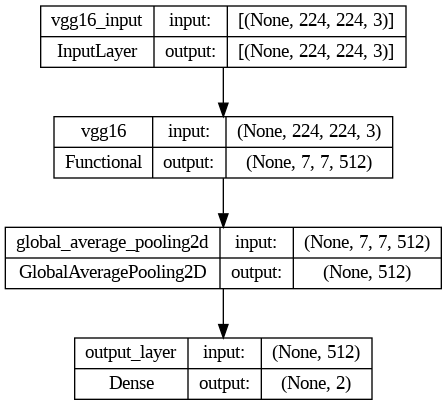

In [14]:
keras.utils.plot_model(model_1, show_shapes=True)

##### 학습

In [ ]:
g_drive_root = "/content/drive/MyDrive"
save_path = os.path.join(g_drive_root, 'saved_model', 'cat_dog_transfer_learning')
mc_callback = keras.callbacks.ModelCheckpoint(save_path, save_best_only=True, save_weights_only=True, verbose=1)
es_callback = keras.callbacks.EarlyStopping(patience=3, verbose=2)  #(patience=10, verbose=2) # epoch 을 크게 잡은 경우.

In [ ]:
hist = model_1.fit(train_iter,
                   epochs=N_EPOCH,
                   steps_per_epoch=len(train_iter),
                   validation_data=val_iter,
                   validation_steps=len(val_iter),
                   callbacks=[mc_callback, es_callback])

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.9604 - accuracy: 0.7730
Epoch 1: val_loss improved from inf to 0.42340, saving model to /content/drive/MyDrive/saved_model/cat_dog_transfer_learning/ckpt
32/32 [==============================] - 51s 1s/step - loss: 0.9604 - accuracy: 0.7730 - val_loss: 0.4234 - val_accuracy: 0.9070
Epoch 2/10
32/32 [==============================] - ETA: 0s - loss: 0.3564 - accuracy: 0.9030
Epoch 2: val_loss improved from 0.42340 to 0.25310, saving model to /content/drive/MyDrive/saved_model/cat_dog_transfer_learning/ckpt
32/32 [==============================] - 30s 928ms/step - loss: 0.3564 - accuracy: 0.9030 - val_loss: 0.2531 - val_accuracy: 0.9430
Epoch 3/10
32/32 [==============================] - ETA: 0s - loss: 0.2264 - accuracy: 0.9285
Epoch 3: val_loss improved from 0.25310 to 0.19837, saving model to /content/drive/MyDrive/saved_model/cat_dog_transfer_learning/ckpt
32/32 [==============================] - 30s 916ms/step - l

##### 평가

In [17]:
model_1.evaluate(test_iter)

16/16 [==============================] - 4s 238ms/step - loss: 0.1255 - accuracy: 0.9700


[0.1254580169916153, 0.9700000286102295]

### 새로운 데이터 추론

#### 추론 함수

In [ ]:
def predict_func(image_path, model, preprocess_func, image_size=224):
    """
    이미지 경로를 받아서 모델을 이용해 추론결과를 반환하는 함수
    [parameter]
        image_path: str - 추론한 이미지의 경로
        model: Model객체 - 개/고양이 분류를 위해 학습된 딥러닝 모델
        prerpocess_input: function - 이미지 전처리 함수 객체
    [반환값]
        tuple: (예측확률, 예측라벨, 예측라벨이름)
    """
    class_names = ["고양이", "개"]

    # 이미지 로드
    img = load_img(img_path, target_size=(224, 224))
    img_arr = img_to_array(img)[np.newaxis, ...]

    # 전처리
    input_tensor = preprocess_func(img_arr)

    # 추론 - shape: (1: 추론개수, 2: class별 확률)
    pred = model.predict(input_tensor)

    # 결과 후처리
    proba = pred[0].max(axis=-1)
    class_idx = pred[0].argmax(axis=-1)
    class_name = class_names[class_idx]

    return proba, class_idx, class_name

In [ ]:
img_path = 'test_img/dog.jpg'
# img_path = 'test_img/cat.jpg'
predict_func(img_path, model_1, applications.vgg16.preprocess_input)

In [23]:
img_path = 'test_img/dog2.jpg'
# img_path = 'test_img/cat2.jpg'
predict_func(img_path, model_1, applications.vgg16.preprocess_input)

# (0.9999999, 1, '개')

1/1 [==============================] - 0s 18ms/step


(1.0, 1, '개')

## Fine-tuning(미세조정)
- Transfer Learning을 위한 Pretrained 모델을 내 데이터셋(Custom Dataset)으로 재(추가)학습시키는 것을 fine tunning 이라고 한다.
- 주어진 문제에 더 적합하도록 Feature Extractor(backbone)의 가중치들도 조정 한다.

### Fine tuning 전략
![transfer02](figures/09_transfer_03.png)

- **세 전략 모두 추론기는 trainable로 한다.**

**<font size='5'>1. 전체 모델을 전부 학습시킨다.(1번)</font>**    
- Pretrained 모델의 weight는 Feature extraction 의 초기 weight 역할을 한다.
- **Train dataset의 양이 많고** Pretrained 모델이 학습했던 dataset과 Custom dataset의 class간의 유사성이 **낮은 경우** 적용.
- 학습에 시간이 많이 걸린다.
    
    
**<font size='5'>2. Pretrained 모델 Bottom layer들(Input과 가까운 Layer들)은 고정시키고 Top layer의 일부를 재학습시킨다.(2번)</font>**     
- **Train dataset의 양이 많고** Pretrained 모델이 학습했던 dataset과 Custom dataset의 class간의 유사성이 **높은 경우** 적용.
- **Train dataset의 양이 적고** Pretained 모델이 학습했던 dataset과 custom dataset의 class간의 유사성이 **낮은 경우** 적용
    
    
**<font size='5'>3. Pretrained 모델 전체를 고정시키고 classifier layer들만 학습시킨다.(3번)</font>**      
- **Train dataset의 양이 적고** Pretrained 모델이 학습했던 dataset과 Custom dataset의 class간의 유사성이 **높은 경우** 적용.
  
  
> **Custom dataset:** 내가 학습시키고자 하는 dataset
> 1번 2번 전략을 Fine tuning 이라고 한다.

![fine tuning](figures/09_finetuning.png)

## Model, Layer의 weight 조회
- Transfer Learning을 구현하기 위해 기존 학습된 모델(Pretrained Model)의 Layer를 변경시켜야 한다.

### Model에서 Layer들 조회
- model객체.layers
    - 모델을 구성하는 layer 객체들을 담은 리스트
- model객체.get_layer(Layer이름:str)
    - argument로 전달한 이름의 Layer객체를 반환
    

### Model과 Layer의 weight들 조회 및 설정
- Layer와 Model은 **Weight 조회**와 관련해 세가지 **속성**을 제공
    - **weights:** 레이어의 모든 weight들을 담은 리스트
    - **trainable_weights:** Train(학습)시 업데이트 되는 weights들 리스트
    - **non_trainable_weights:** Train(학습)시 업데이트 되지 않는(훈련되지 않는) weights들 리스트
- Layer와 Model은 boolean 값을 가지는 속성 `trainable`을 제공
    - trainable을 **False로** 설정하면 Layer의 weights들이 훈련가능에서 **훈련 불가능** 상태로 변경된다. 이런 상태를 **Frozen**상태 이라고 하며 학습 할 때 weight들이 업데이트 되지 않는다.

In [ ]:
### Layer, weight 조회 기본 예제
test_model = keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(28,28,1), name='my_conv'),
    layers.MaxPooling2D(padding='same'),

    layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(padding='same'),

    layers.Flatten(),
    layers.Dense(units=256, activation='relu'),
    layers.Dense(units=10, activation='softmax', name='output_layer')
])

In [ ]:
test_model.summary()

In [ ]:
# 모델을 구성하는 Layer들 리스트 조회
layer_list = test_model.layers
type(layer_list), len(layer_list)

In [ ]:
print(layer_list[0], layer_list[1])

In [ ]:
# Layer의 이름을 이용해 개별 layer 조회
l1 = test_model.get_layer("my_conv")
print(l1)

In [ ]:
l2 = test_model.get_layer('conv2d')
l2

In [ ]:
# layer의 trainable 상태 조회(변경)
print(l1.trainable)
l1.trainable = False
print(l1.trainable)

In [ ]:
# layer의 이름 조회(변경은 안됨)
l1.name

In [ ]:
# layer의 파라미터들을 조회
param = l1.weights
type(param), len(param)
param[0].shape, param[1].shape   # weight, bias

### Fine Tuning 예제

#### Pretrained 모델 Bottom layer들(Input과 가까운 Layer들)은 고정시키고 Top layer의 일부를 재학습

- Conv_base에서 가장 Top부분에 있는 레이어에 대해 fine-tuning.
    - 앞의 layer들은 비교적 일반적이고 재사용 가능한 feature를 학습
    - 너무 많은 parameter를 학습시키면 overfitting의 위험이 있음 (특히 새로운 데이터의 수가 적을 때)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications, layers, models, callbacks, optimizers

import numpy as np
import random

np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

In [ ]:
LEARNING_RATE = 0.001
N_EPOCH = 10 # 100
N_BATCH = 64

##### 모델 정의, 컴파일

In [ ]:
def get_model_2(block_name='block5_conv2'):
    """
    backbone 네트워크로 VGG 16을 사용.
    block5_conv2, bloc5_conv3 는 추가 학습이 되도록 구현.  => trainable, 나머지는 frozen
    [parameter]
        block_name: str - trainable을 시작할 layer의 이름.
                          지정한 block 아래 있는 layer들을 trainable로 한다.
    [retunr]
        model
    """
    model = keras.Sequential()
    backbone = applications.VGG16(include_top=False, input_shape=(224, 224, 3))

    # block5_conv2 를 포함해서 그 다음 레이어들의 trainable 속성을 True로 변환.
    is_trainable = False
    for layer in backbone.layers:
        if layer.name == block_name:
            is_trainable = True
        layer.trainable = is_trainable

    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(2, activation='softmax', name='output_layer'))

    # 컴파일
    model.compile(optimizer=optimizers.Adam(LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
model2 = get_model_2()
model2.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 output_layer (Dense)        (None, 2)                 514       
                                                                 
Total params: 14846530 (56.64 MB)
Trainable params: 4851458 (18.51 MB)
Non-trainable params: 9995072 (38.13 MB)
_________________________________________________________________


##### 학습

In [11]:
train_iter2, val_iter2, test_iter2 = get_generator(applications.vgg16.preprocess_input)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [12]:
import os
save_path2 = "/content/drive/MyDrive/saved_model/cat_dog_fine_tuning"
mc_callback2 = callbacks.ModelCheckpoint(save_path2, save_best_only=True, verbose=2)
es_callback2 = callbacks.EarlyStopping(patience=3, verbose=2)

hist2 = model2.fit(train_iter2,
                  epochs=N_EPOCH,
                  steps_per_epoch=len(train_iter2),
                  validation_data=val_iter2,
                  validation_steps=len(val_iter2),
                  callbacks=[mc_callback2, es_callback2])

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 7.8851 - accuracy: 0.5985
Epoch 1: val_loss improved from inf to 1.07003, saving model to /content/drive/MyDrive/saved_model/cat_dog_fine_tuning
32/32 [==============================] - 59s 1s/step - loss: 7.8851 - accuracy: 0.5985 - val_loss: 1.0700 - val_accuracy: 0.6640
Epoch 2/10
32/32 [==============================] - ETA: 0s - loss: 0.2321 - accuracy: 0.9000
Epoch 2: val_loss improved from 1.07003 to 0.16595, saving model to /content/drive/MyDrive/saved_model/cat_dog_fine_tuning
32/32 [==============================] - 33s 1s/step - loss: 0.2321 - accuracy: 0.9000 - val_loss: 0.1660 - val_accuracy: 0.9410
Epoch 3/10
32/32 [==============================] - ETA: 0s - loss: 0.1348 - accuracy: 0.9480
Epoch 3: val_loss improved from 0.16595 to 0.14169, saving model to /content/drive/MyDrive/saved_model/cat_dog_fine_tuning
32/32 [==============================] - 34s 1s/step - loss: 0.1348 - accuracy: 0.9480 - val_lo

##### 최종 평가

In [ ]:
model2.evaluate(test_iter2)

In [13]:
saved_model2 = keras.models.load_model(save_path2)

In [14]:
saved_model2.evaluate(test_iter2)

16/16 [==============================] - 5s 259ms/step - loss: 0.0712 - accuracy: 0.9740


[0.07124575972557068, 0.9739999771118164]

### 새로운 데이터 추론

In [22]:
img_path = 'dog2.jpg'
# img_path = 'cat2.jpg'
predict_func(img_path, saved_model2, applications.vgg16.preprocess_input)

1/1 [==============================] - 0s 19ms/step


(1.0, 1, '개')